# SpringBoard - Relax Challenge

In [733]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from collections import Counter
%matplotlib inline

In [734]:
# load and examine the data
user_engagement_df = pd.read_csv('takehome_user_engagement.csv')
user_engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


**Note:** 'takehome_users.csv' was re-encoded to utf-8 to allow proper opening.

In [735]:
users_df = pd.read_csv('takehome_users.csv')
print(users_df.shape)
users_df.head()

(12000, 10)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,1/17/2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [736]:
# lets examine the user data to see who is actually using the application
print('There are {} users who have ever used the application.'\
          .format(len(list(user_engagement_df['user_id'].unique()))))
print('There are {} signed up for the application.'\
          .format(len(list(users_df['object_id'].unique()))))

print('There is a discrepancy of {} users.'\
          .format(int(len(list(users_df['object_id'].unique()))) 
                  - int(len(list(user_engagement_df['user_id'].unique())))))

There are 8823 users who have ever used the application.
There are 12000 signed up for the application.
There is a discrepancy of 3177 users.


In [737]:
# how many people never signed in?
print('There are ', len(users_df[users_df['last_session_creation_time'].isnull()]), 'inactive users.')

There are  3177 inactive users.


So, at this point we have two data sets. The first, we can use to determine if a user is "adopted" the app. Then with the second data set we can use these determined ID's to then produce and evaluate a predictive model. As part of this process we will have to deal with any missing, duplicate, and/or irrelevant data points.

As outlined, in this case an adopted user is any ID that had logged in on at least 3 serarate occasions in a 7 day period.

# Data Wrangling

In [738]:
# Check for missing data in each of the supplied data sets
print('user_engagement')
print(user_engagement_df.isnull().any())
print("\n")
print('user_engagement')
print(users_df.isnull().any())

user_engagement
time_stamp    False
user_id       False
visited       False
dtype: bool


user_engagement
object_id                     False
creation_time                 False
name                          False
email                         False
creation_source               False
last_session_creation_time     True
opted_in_to_mailing_list      False
enabled_for_marketing_drip    False
org_id                        False
invited_by_user_id             True
dtype: bool


In [739]:
# How much missing data do we have e.g. if we drop it how much info is gone?
print(users_df['last_session_creation_time'].isnull().value_counts())
print(users_df['invited_by_user_id'].isnull().value_counts())

False    8823
True     3177
Name: last_session_creation_time, dtype: int64
False    6417
True     5583
Name: invited_by_user_id, dtype: int64


Missing values in significant number from these two columns.

In [740]:
# bring in some datetime
user_engagement_df['time_stamp'] = pd.to_datetime(user_engagement_df['time_stamp'])

In [781]:
# How many values does 'visited' take?
user_engagement_df['visited'].unique()

array([1], dtype=int64)

In [742]:
# time to add in the adopted user feature so that we can categorize the data
seven_days = datetime.timedelta(7)
adopted_dict = {}

for user_id in sorted(list(user_engagement_df['user_id'].unique())):
    
    adopted_user = False
    temp = user_engagement_df[user_engagement_df['user_id'] == user_id]
    temp = temp.sort_values('time_stamp')
    
    for row in temp.itertuples():
        if adopted_user == True:
            continue
        this_time = temp.get_value(row[0], 'time_stamp')
        if len(temp[(temp['time_stamp'] >= this_time) & (temp['time_stamp'] <= (this_time + seven_days))]) >= 3:
            adopted_user = True
    
    adopted_dict[user_id] = adopted_user

In [789]:
# what percentage of the users are sticking around?
count_df = pd.DataFrame.from_dict(Counter(list(adopted_dict.values())), orient='index').reset_index()

print('We have analyzed logs for', len(adopted_dict), 'unique users.')
print(round((count_df.loc[1][1]/(count_df.loc[1][1]+count_df.loc[0][1])*100),2) ,'of users are adopted-users.')

We have analyzed logs for 8823 unique users.
18.77 of users are adopted-users.


In [744]:
# Create adopted target variable and display dataset again
users_df['adopted'] = False
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,False
2,3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
3,4,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
4,5,1/17/2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False


In [745]:
# Replace adopted target class with correct flags
for row in (users_df[np.logical_not(users_df['last_session_creation_time'].isnull())]).itertuples():
    adopted_value = adopted_dict[users_df.get_value(row[0], 'object_id')]
    users_df.set_value(row[0], 'adopted', adopted_value)
    
print('{:.2f}% of all users who have signed up for the application are considered \'adopted users\'.'\
          .format(len(users_df[users_df['adopted'] == True])/len(users_df)*100))

13.80% of all users who have signed up for the application are considered 'adopted users'.


In [746]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted                       12000 non-null bool
dtypes: bool(1), float64(2), int64(4), object(4)
memory usage: 949.3+ KB


In [747]:
# Check on the higher risk/more defined features
for feature in ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']:
    print('{} feature:'.format(feature))
    print(users_df[feature].value_counts(), end='\n\n')

creation_source feature:
ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

opted_in_to_mailing_list feature:
0    9006
1    2994
Name: opted_in_to_mailing_list, dtype: int64

enabled_for_marketing_drip feature:
0    10208
1     1792
Name: enabled_for_marketing_drip, dtype: int64



In [748]:
users_df['last_session_creation_time'] = users_df['last_session_creation_time'].fillna(users_df['last_session_creation_time'].median())


users_df['creation_time'] = pd.to_datetime(users_df['last_session_creation_time'])
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])
# day of the week account created
users_df['day_created'] = users_df['creation_time'].apply(lambda x: x.dayofweek)
# hour of the day account created
users_df['hour_created'] = users_df['creation_time'].apply(lambda x: x.hour)
# drop the original column
users_df.drop('creation_time', axis=1, inplace=True)

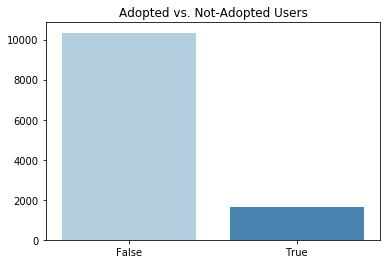

In [749]:
# Take another look at the distribution of the target class
sns.barplot(x = list(users_df['adopted'].value_counts().index), y = users_df['adopted'].value_counts(), palette='Blues')
plt.ylabel('')
plt.title('Adopted vs. Not-Adopted Users');

As there is a heavy imbalance in the classes here I will split the data into training and testing data and then oversample the training the data to balance out the classes w/o distorting the testing data.

In [750]:
users_df.drop(['name', 'email', 'invited_by_user_id', 'object_id'], axis=1, inplace=True)

In [751]:
users_df.head()

,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,day_created,hour_created
0,GUEST_INVITE,1.398139e+09,1,0,11,False,3,0
1,ORG_INVITE,1.396238e+09,0,0,1,True,3,0
2,ORG_INVITE,1.363735e+09,0,0,94,False,3,0
3,GUEST_INVITE,1.369210e+09,0,0,1,False,3,0
4,GUEST_INVITE,1.358850e+09,0,0,193,False,3,0


In [752]:
#########################################################################################

In [753]:
# One-hot-encode creation_source
df_encoded = pd.get_dummies(users_df, columns = ['creation_source'])

In [754]:
X = df_encoded.drop('adopted', axis=1)
y = df_encoded['adopted']

In [755]:
# Split into train and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, 
                                                           random_state=2007, stratify=users_df['adopted'])


In [756]:
y_train.head()

5655    False
7390    False
3313    False
8560    False
1656    False
Name: adopted, dtype: bool

In [757]:
X_train.head()

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,day_created,hour_created,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
5655,1.382888e+09,1,0,216,3,0,0,1,0,0,0
7390,1.360001e+09,0,0,220,3,0,0,0,1,0,0
3313,1.391318e+09,0,0,274,3,0,0,1,0,0,0
8560,1.399979e+09,0,0,44,3,0,0,1,0,0,0
1656,1.382888e+09,0,0,412,3,0,0,0,1,0,0


In [758]:
#SMOTE oversampling to balance out the classes

from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_resampled = ADASYN().fit_sample(X_train, y_train)
# X_resampled, y_resampled = X_train, y_train
#ADASYN().fit_sample(X, y)

print(sorted(Counter(y_resampled).items()))


[(False, 7241), (True, 7161)]


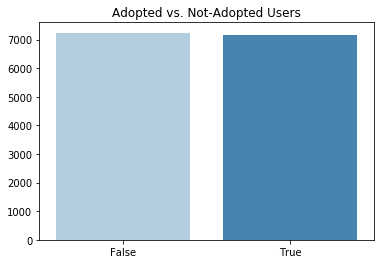

In [759]:
# Take a look at the distribution of the enhanced target class
sns.countplot(y_resampled, palette='Blues')
plt.ylabel('')
plt.title('Adopted vs. Not-Adopted Users');

# Predictive Models and Feature Importance

I will begin by examining the OOB performance of several different relevant model in order to glean the best one to start with and then fine tune.

In [761]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

In [762]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [763]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC()))
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))

In [764]:
names = []
scores = []
for name, model in tqdm(models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
    names.append(name)
tr_split = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:06<00:00,  1.04it/s]


  Name     Score
0  KNN  0.909167
1  SVC  0.861944
2   LR  0.861944
3   DT  0.878333
4  GNB  0.861944
5   RF  0.908056
6   GB  0.913889


In [765]:
names = []
scores = []
for name, model in tqdm(models):
    
    kfold = KFold(n_splits=10, random_state=10) 
    score = cross_val_score(model, X, y, cv=kfold, scoring='accuracy').mean()
    
    names.append(name)
    scores.append(score)
kf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
print(kf_cross_val)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:39<00:00, 22.73s/it]


  Name     Score
0  KNN  0.910500
1  SVC  0.862000
2   LR  0.862000
3   DT  0.871167
4  GNB  0.862000
5   RF  0.909667
6   GB  0.918333


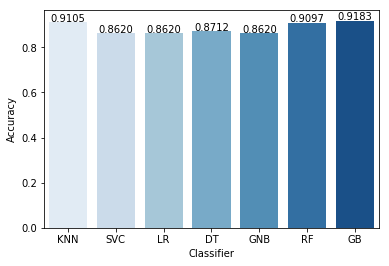

In [766]:
# Visualize model model scores
axis = sns.barplot(x = 'Name', y = 'Score', data = kf_cross_val, palette='Blues')
axis.set(xlabel='Classifier', ylabel='Accuracy')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
plt.show()

Train and tune a single model.

In [794]:
clf = GradientBoostingClassifier(verbose=True)
clf.fit(X_train, y_train)
print('Train Score:', round(clf.score(X_train,y_train),3))
print('Test Score:', round(clf.score(X_test,y_test),3))

      Iter       Train Loss   Remaining Time 
         1           0.7090            0.49s
         2           0.6539            0.59s
         3           0.6143            0.58s
         4           0.5839            0.62s
         5           0.5597            0.63s
         6           0.5399            0.63s
         7           0.5235            0.61s
         8           0.5099            0.62s
         9           0.4975            0.62s
        10           0.4878            0.60s
        20           0.4371            0.44s
        30           0.4208            0.34s
        40           0.4120            0.27s
        50           0.4024            0.22s
        60           0.3945            0.17s
        70           0.3878            0.13s
        80           0.3828            0.08s
        90           0.3799            0.04s
       100           0.3751            0.00s
Train Score: 0.929
Test Score: 0.914


In [769]:
# TP / FP 
confusion_matrix(y_test, clf.predict(X_test))

array([[2986,  117],
       [ 193,  304]], dtype=int64)

Examine the model feature importance.

In [770]:
clf.feature_importances_.shape


(11,)

In [771]:
features = pd.Series(clf.feature_importances_, index=X.columns)

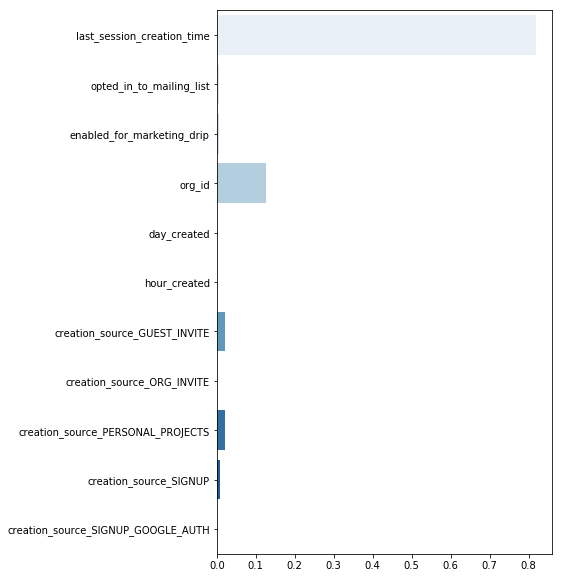

In [772]:
plt.figure(figsize=(6,10))
sns.barplot(y=X.columns, x=clf.feature_importances_, palette='Blues')

In [773]:
# Find feature importances
feature_importance = pd.DataFrame(clf.feature_importances_).T
feature_importance.columns = list(X_train.columns)
feature_importance = feature_importance.T
feature_importance.columns = ['feature_importance']
feature_importance.sort_values('feature_importance', ascending=False)

,feature_importance
last_session_creation_time,0.818172
org_id,0.125527
creation_source_PERSONAL_PROJECTS,0.019828
creation_source_GUEST_INVITE,0.019736
creation_source_SIGNUP,0.007693
opted_in_to_mailing_list,0.004557
enabled_for_marketing_drip,0.004488
day_created,0.000000
hour_created,0.000000
creation_source_ORG_INVITE,0.000000


As can be seen above the most important feature is the most recent log-in time. 

now lets try some hyperparameter tunning.

In [774]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                                min_samples_split=500,
                                                               min_samples_leaf=50,
                                                               max_depth=8,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=2007), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=500,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=2007, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(20, 81, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [775]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\zalle\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.89515, std: 0.01222, params: {'n_estimators': 20},
  mean: 0.89671, std: 0.01413, params: {'n_estimators': 30},
  mean: 0.89679, std: 0.01219, params: {'n_estimators': 40},
  mean: 0.89831, std: 0.01253, params: {'n_estimators': 50},
  mean: 0.89807, std: 0.01180, params: {'n_estimators': 60},
  mean: 0.89899, std: 0.01139, params: {'n_estimators': 70},
  mean: 0.89830, std: 0.01056, params: {'n_estimators': 80}],
 {'n_estimators': 70},
 0.8989862964017978)

In [776]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}

gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                               n_estimators=60, 
                                                               max_features='sqrt', 
                                                               subsample=0.8, 
                                                               random_state=2007), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch2.fit(X_train,y_train)

gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

C:\Users\zalle\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.89541, std: 0.01171, params: {'max_depth': 5, 'min_samples_split': 200},
  mean: 0.89684, std: 0.01184, params: {'max_depth': 5, 'min_samples_split': 400},
  mean: 0.89796, std: 0.00857, params: {'max_depth': 5, 'min_samples_split': 600},
  mean: 0.89493, std: 0.01492, params: {'max_depth': 5, 'min_samples_split': 800},
  mean: 0.89298, std: 0.01787, params: {'max_depth': 5, 'min_samples_split': 1000},
  mean: 0.89502, std: 0.01342, params: {'max_depth': 7, 'min_samples_split': 200},
  mean: 0.89897, std: 0.01047, params: {'max_depth': 7, 'min_samples_split': 400},
  mean: 0.89882, std: 0.01232, params: {'max_depth': 7, 'min_samples_split': 600},
  mean: 0.89717, std: 0.01260, params: {'max_depth': 7, 'min_samples_split': 800},
  mean: 0.89421, std: 0.01548, params: {'max_depth': 7, 'min_samples_split': 1000},
  mean: 0.89225, std: 0.01139, params: {'max_depth': 9, 'min_samples_split': 200},
  mean: 0.89696, std: 0.00834, params: {'max_depth': 9, 'min_samples_split': 400},
  

In [777]:
clf_tuned.fit(X_train,y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.7515           0.0514            0.62s
         2           0.7088           0.0396            0.65s
         3           0.6850           0.0263            0.74s
         4           0.6612           0.0259            0.68s
         5           0.6324           0.0237            0.68s
         6           0.6222           0.0197            0.67s
         7           0.6036           0.0147            0.66s
         8           0.5838           0.0155            0.64s
         9           0.5808           0.0121            0.64s
        10           0.5586           0.0127            0.63s
        20           0.4787           0.0055            0.43s
        30           0.4495           0.0017            0.30s
        40           0.4172           0.0004            0.22s
        50           0.4080           0.0002            0.14s
        60           0.4133           0.0004            0.07s
       

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=6,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=800,
              min_weight_fraction_leaf=0.0, n_estimators=70,
              presort='auto', random_state=2007, subsample=0.85,
              verbose=True, warm_start=False)

In [778]:
clf_tuned = GradientBoostingClassifier(learning_rate=0.05, 
                                       n_estimators=70, 
                                       max_features='auto', 
                                       subsample=0.85,
                                       max_depth= 6,
                                       min_samples_split= 800,
                                       random_state=2007,
                                       verbose=True)

In [779]:
clf_tuned.fit(X_train,y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.7515           0.0514            0.62s
         2           0.7088           0.0396            0.65s
         3           0.6850           0.0263            0.63s
         4           0.6612           0.0259            0.61s
         5           0.6324           0.0237            0.62s
         6           0.6222           0.0197            0.63s
         7           0.6036           0.0147            0.63s
         8           0.5838           0.0155            0.64s
         9           0.5808           0.0121            0.62s
        10           0.5586           0.0127            0.61s
        20           0.4787           0.0055            0.43s
        30           0.4495           0.0017            0.31s
        40           0.4172           0.0004            0.23s
        50           0.4080           0.0002            0.15s
        60           0.4133           0.0004            0.07s
       

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=6,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=800,
              min_weight_fraction_leaf=0.0, n_estimators=70,
              presort='auto', random_state=2007, subsample=0.85,
              verbose=True, warm_start=False)

In [793]:
print('Train Score:', round(clf_tuned.score(X_train,y_train),3))
print('Test Score:', round(clf_tuned.score(X_test,y_test),3))

Train Score: 0.925
Test Score: 0.915


#Conclusion:

With approximatly **81%** of the userbase no considered non adoptive users, we have an obvious area for improvment in user engagment. This is also exemplified by the fact that we have several thousand users who, after creating an account, never engaged with the system (loged in). From the feature importances the last log in time was the most highly correlated with a positive prediction, which is not surprising. However, I am not certain how useful the is as a real world predictor as those who have logged in more recently are more likely to be in the engaged crowed, and thus this dilutes its usefulness as a predictor of whether or not a novel user will become an adopted user. My recommendations at this point would be to identify the top sources of engaged users (sign-up origin) and increase marketing efforts there. Further, we can conduct more detailed surveys amoungst adopted users to attempt to identify new commonfeatures to add to the model that may increase its validity. 